## Why is modeling helpful?

### 1.

Predictive modeling can show trends and patterns in the number of surgeries scheduled vs the actual number of surgeries performed.

### 2.

Predictive modeling can predict the number of actual surgeries performed on a given day, which can help with resource and staff allocation.

### 3.

With additional data, one can identify factors related to surgeon availability, seasonality, or health trends such as COVID-19 that affect the number of actual surgeries vs number of schedules surgeries; the hospital can thus prepare accordingly.

### 4.

Predictive modeling allows for automatic scheduling of surgeons, patients, nurses, and other important hospital staff around high volume or low volume periods to ensure maximizing resource utilization and minimizing waste.

### 5.

Predictive modeling can be used as a benchmark to see if the hospital's current policies are allowing it to function most efficiently as well as evaluate new changes.

In [181]:
import pandas as pd
import matplotlib.pyplot as plt

dat = pd.read_csv('ElectiveSurgeryData.csv')

In [182]:
dat.shape

(241, 19)

In [183]:
dat.columns = dat.columns.str.strip()
dat.head(10)

,SurgDate,DOW,T - 28,T - 21,T - 14,T - 13,T - 12,T - 11,T - 10,T - 9,T - 8,T - 7,T - 6,T - 5,T - 4,T - 3,T - 2,T - 1,Actual
0,10/10/2011,Mon,38,45,60,63,65,70,73,73,73,80,84,89,94,98,100,104,106
1,10/11/2011,Tue,35,47,65,68,78,82,82,82,86,89,92,95,99,99,99,114,121
2,10/12/2011,Wed,26,43,54,62,72,72,72,74,87,94,96,101,102,102,106,114,126
3,10/13/2011,Thu,28,48,65,70,72,72,72,82,87,91,94,94,94,97,98,103,114
4,10/14/2011,Fri,31,40,50,50,50,54,62,68,71,73,73,73,78,83,87,94,106
5,10/17/2011,Mon,41,56,65,69,72,73,77,78,78,80,86,85,86,92,96,102,111
6,10/18/2011,Tue,44,55,69,74,79,83,83,83,93,92,96,103,105,105,107,114,122
7,10/19/2011,Wed,32,40,62,66,71,73,73,84,86,87,89,96,96,96,102,119,127
8,10/20/2011,Thu,33,44,62,66,67,67,79,77,88,90,98,98,98,105,111,118,116
9,10/21/2011,Fri,20,32,48,48,48,47,52,55,59,61,61,61,69,72,70,88,99


### RF

c:\Users\henry\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


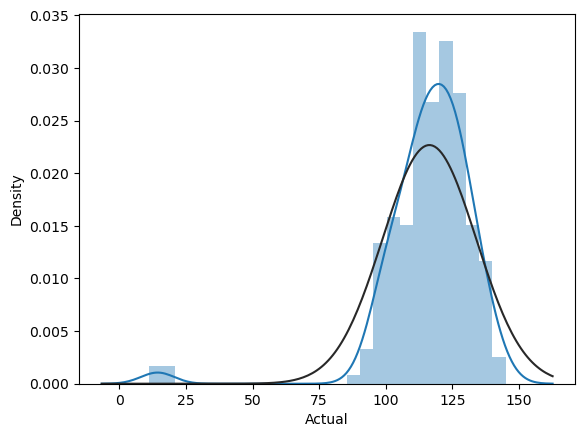

<Figure size 640x480 with 0 Axes>

In [184]:
#histogram and normal probability plot
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from scipy.stats import norm
import statistics as stats
import seaborn as sns
import statsmodels.api as sm
sns.distplot(dat['Actual'],fit=norm)
fig = plt.figure()

In [185]:
# These dates have significantly less schedules surgeries due to being holidays.
# We will remove them since they are clearly outliers.
dat.loc[dat['Actual'] < 20]

,SurgDate,DOW,T - 28,T - 21,T - 14,T - 13,T - 12,T - 11,T - 10,T - 9,T - 8,T - 7,T - 6,T - 5,T - 4,T - 3,T - 2,T - 1,Actual
33,11/25/2011,Fri,0,0,1,1,1,1,2,2,2,3,3,3,3,4,7,12,16
53,12/23/2011,Fri,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,14
54,12/26/2011,Mon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,16
58,12/30/2011,Fri,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,6,11


In [186]:
dat = dat.drop(dat[dat['Actual'] < 20].index)
dat.shape

(237, 19)

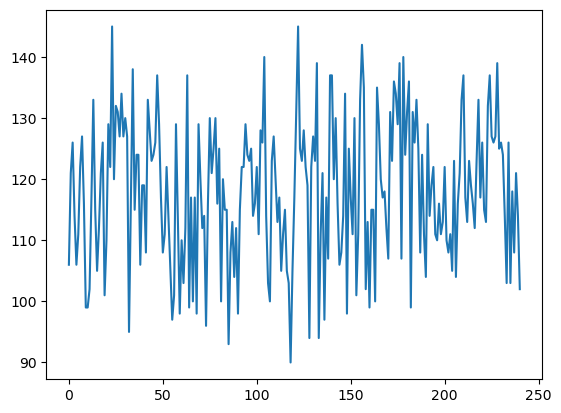

In [187]:
plt.plot(dat["Actual"])

In [188]:
# data is time series, actual of one day could be related to actual of previous day
import datetime as dt
dat['Actual_prev'] = dat['Actual'].shift(1)
dat = dat.dropna()
dat['SurgDate'] = pd.to_datetime(dat['SurgDate']).map(dt.datetime.toordinal)


In [189]:
# One hot encode day of week
one_hot_dat = pd.get_dummies(dat, columns=['DOW'])

In [190]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=2)
X = one_hot_dat.drop(labels = 'Actual', axis = 1)
Y = one_hot_dat['Actual']
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    train_x, test_x = X.iloc[train_index, :], X.iloc[test_index, :]
    train_y, test_y = Y.iloc[train_index], Y.iloc[test_index]

In [191]:
one_hot_dat['SurgDate'].dtype

dtype('int64')

In [192]:
rf = RandomForestRegressor(n_estimators=1000)
rf.fit(train_x, train_y)

rf.predict(test_x)

array([101.487, 125.418, 125.14 , 122.074, 110.837, 122.249, 114.126,
       108.125, 128.249, 116.265, 129.744, 125.654, 135.619, 133.909,
       106.748, 127.11 , 123.675, 123.227, 137.877,  96.335, 129.26 ,
       113.873, 120.211, 123.647, 108.196, 130.564, 108.217, 103.94 ,
       115.21 , 115.959, 119.723, 121.314, 116.043, 104.615, 115.675,
       107.838, 115.046, 113.412, 106.873, 109.88 , 112.574, 102.637,
       118.729, 106.261, 114.034, 120.749, 113.486, 127.153, 119.137,
       115.456, 119.235, 121.641, 120.151, 103.332, 126.162, 132.099,
       119.291, 126.372, 113.097, 120.604, 126.488, 127.884, 136.327,
       129.23 , 126.509, 138.626, 120.18 , 131.265, 121.563, 120.523,
        99.984, 119.575,  96.727, 114.722, 107.22 , 117.042, 115.5  ,
       106.936])

In [193]:
test_y

163    100
164    135
165    129
166    120
167    117
      ... 
236    118
237    108
238    121
239    114
240    102
Name: Actual, Length: 78, dtype: int64

### Barchart

In [29]:
df = dat.groupby(['DOW']).mean().reset_index()[["DOW", "Actual"]]

,DOW,Actual
0,Fri,105.612245
1,Mon,116.255319
2,Thu,124.083333
3,Tue,119.081633
4,Wed,117.041667


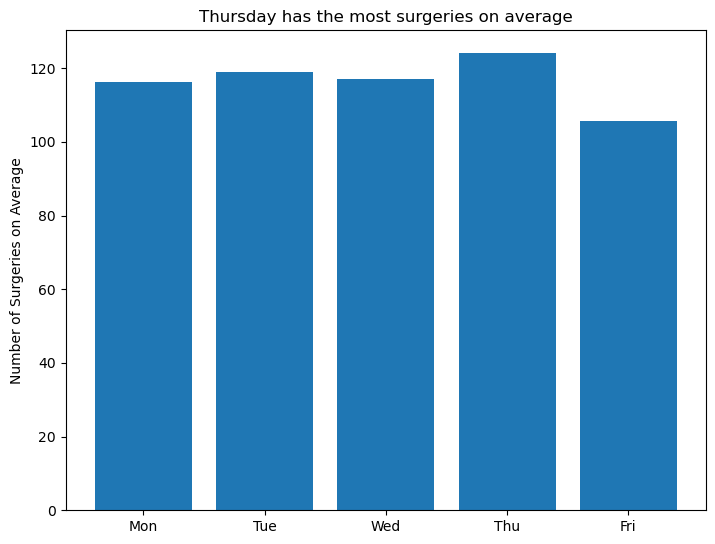

In [41]:
df['key'] = [5,1,4,2,3]
df_sorted = df.sort_values(by = 'key')[['DOW', 'Actual']]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df_sorted["DOW"], df_sorted["Actual"])
plt.title('Thursday has the most surgeries on average')
plt.ylabel('Number of Surgeries on Average')
plt.show()